In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import time
plt.ion()   # interactive mode

In [2]:
torch.manual_seed(1994)

In [3]:
class custom_model:
    
    def __init__(self, model_type,unfreeze_layers, freeze_factor = 1 ,pretrained = True, output_dir = "./runs/"):
        
        if torch.cuda.is_available():      
            self.device = torch.device("cuda:0")
            print("Model set up on the GPU")
            
        
        else:
            self.device = torch.device("cpu")
            print("Running on the CPU")
        
        
        # Define the backbone model
        if model_type == "resnet101":
            self.model = models.resnet101(pretrained=pretrained)
        
        elif model_type == "resnet50":
            self.model = models.resnet50(pretrained=pretrained)        
        
        else: 
            print("model type unrecognised")
            
        print(f"Model backbone set to: {model_type}")
        
        # Push the model to device
        self.model = self.model.to(self.device)

        self.unfreeze_layers = unfreeze_layers
        self.freeze_factor = freeze_factor
        
        if self.freeze_factor == 1:
            for name,child in self.model.named_children():
                if name not in self.unfreeze_layers:
                    for param in child.parameters():
                        param.requires_grad = False
        
        else:
            for name,child in self.model.named_children():
                if name not in self.unfreeze_layers:
                    for param in child.parameters():
                        param.requires_gra = False
                    
                elif name in self.unfreeze_layers:    
                    for param in list(child.parameters())[int(self.freeze_factor*len(list(child.parameters()))):]:
                        param.requires_grad = False

                        
        # Defines the output dir for the model to be saved
        self.output_dir = output_dir
        
        from torch.utils.tensorboard import SummaryWriter
        self.writer = SummaryWriter(self.output_dir,)
            
    
    def train(self, loss_func, optimizer, lr_scheduler,learning_rate, epochs, trainloader, valloader, eval_period = 100 ):

        self.trainloader = trainloader
        self.valloader = valloader
        self.learning_rate = learning_rate
        self.eval_period = eval_period
        self.epochs = epochs
        
        
        # Params of the 4th layer to confirm later 
        # that layers are correctly frozen
        self._original_weight = list(self.model.layer4.parameters())[0]
        
        
        print(f"Eval Period set to: {self.eval_period}")

        self.criterion = loss_func()
        self.optimizer = optimizer(filter(lambda p: p.requires_grad, self.model.parameters()),lr = self.learning_rate)
        self.lr_scheduler = lr_scheduler(self.optimizer)

        train_epoch_loss = []
        train_epoch_acc  = []

        val_epoch_loss = []
        val_epoch_acc = []

        best_val_acc = 0.0
        running_training_loss = 0.0

        for epoch in range(self.epochs):
            
            # check for first 3 epochs whether the layers
            # are actually frozen and the weights do not change
            
            if 0 < epoch < 3:
                
                print(f"Did the Weights change in epoch: {epoch}?")
                if list(self.model.layer4.parameters())[0].cpu().numpy().all() == self._original_weight[0].cpu().numpy().all():
                    print("No")
                else:
                    print("Yes, abort!!!")
            
            

            train_batch_loss = []
            train_batch_acc = []

            val_batch_loss = []
            val_batch_acc = []

            # train loop
            for idx, data in enumerate(self.trainloader):

                self.model.train()

                inputs,labels = data["image"],data["label"]

                # Place tensors on GPU
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Zero out the accumulated gradients
                self.optimizer.zero_grad()

                outputs = self.model(inputs)

                loss = self.criterion(outputs,labels.float())
                
                running_training_loss+=loss.item()

                #append the mean train loss (woking on a batch)
                #use item() to detach from GPU
                train_batch_loss.append(loss.item())

                # Identify Correct predictions
                correct_preds = [torch.argmax(i)==torch.argmax(j) for i,j in zip(outputs,labels)]
                train_acc = correct_preds.count(True)/len(correct_preds)
                train_batch_acc.append(train_acc)


                # Backwards pass
                loss.backward()


                self.optimizer.step()                                                                
                
                # print out stats every N iterations
                if idx%500 == 0:
                    
                    current_lr = self.optimizer.param_groups[0]['lr']
                    print(f"Current lr: {current_lr}")
                    print(f"Step: {idx}/{len(trainloader)}; Epoch: {epoch+1}/{self.epochs}; Train Batch Loss: {loss.item()}")
            
            
            self.writer.add_scalar("Training Loss", running_training_loss/len(self.trainloader), epoch)
            running_training_loss = 0.0
            
            train_epoch_loss.append(torch.tensor(train_batch_loss).mean())
            train_epoch_acc.append(torch.tensor(train_batch_acc).mean())

            running_val_loss = 0
            print("epoch",epoch)
            print("epoch%eval_per", epoch%self.eval_period)
            # Validation loop every self.eval_period epochs
            eval_count = 0
            if epoch%self.eval_period == 0:
                print(f"Starting evaluating at epoch: {epoch}")
                with torch.no_grad():
                    for idx,data in enumerate(self.valloader):

                        # set model in eval() mode
                        self.model.eval()

                        inputs,labels, self.val_file_name = data["image"], data["label"], data["file_name"]
                        # Place inputs/lables on the GPU
                        inputs = inputs.to(self.device)
                        labels = labels.to(self.device)

                        # Predict outputs
                        outputs = self.model(inputs)

                        # Obtain and append val_batch_loss
                        val_loss = self.criterion(outputs,labels)
                        val_batch_loss.append(loss.item())
                        running_val_loss += val_loss

                        # Obtain and append val_batch_acc
                        correct_preds = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,labels)]

                        val_acc = correct_preds.count(True)/len(correct_preds)
                        val_batch_acc.append(val_acc)
                        
                        
                        
                        if eval_count%3 == 0:
                            
                            all_feature_maps = []
                            
                            for name in data["file_name"][:2]:
                                all_feature_maps.append(ExtractFeatureMaps(self.model, name))
                                
                            all_feature_maps_stacked = np.vstack(all_feature_maps)
                            self.writer.add_image("Feature Maps of every 10th conv layer", all_feature_maps_stacked,global_step=epoch)
                                
                            
                            all_layers_maps = []
                            
                            for i in range(1,5):
                                score_cam = ScoreCam(self.model, f"layer{i}")

                                eval_count+=1

                                top_images = []
                                bottom_images = []

                                images = data["image"]
                                names = data["file_name"]

                                for idx, (image,name) in enumerate(zip(images,names),1):

                                    no_trans, heatmap_image = score_cam.generate_cam(input_image=image, filename=name)
                                    
                                    if idx <= int(len(data)):
                                        top_images.append(np.array(heatmap_image))
                                        
                                    else:
                                        bottom_images.append(np.array(heatmap_image))
                                        
                                top_images = np.hstack(top_images)
                                bottom_images = np.hstack(bottom_images)
                                all_images = np.vstack((top_images,bottom_images))
                                
                                all_layers_maps.append(all_images)
                            
                            all_layers_maps = np.vstack(all_layers_maps)
                            
                            self.writer.add_image("Class Activation Maps, Layers 1-4", all_layers_maps, global_step = epoch)
                                
                                
                                
                                
                            
                            
                            

                    val_epoch_loss.append(torch.tensor(val_batch_loss).mean())
                    val_epoch_acc.append(torch.tensor(val_batch_acc).mean())
                    
                    
                    # Visualise the predictions on the last validation batch
                    
                    print(f"len inputs of last batch: {len(inputs)}")
                    
                    self.writer.add_scalar("Validation Loss", 
                                           running_val_loss/len(self.valloader),
                                           global_step = epoch
                                          )
                    
                    self.writer.add_figure("Predictions vs. GT",
                                           self.plot_classes_preds(inputs, labels),
                                           global_step = epoch
                                          )
                    
                    running_val_loss = 0.0
                    
                    
            # Save the model which yielding best acc
            if val_acc > best_val_acc:
                print(f"Saving model at epoch: {epoch}")
                best_val_acc = val_acc
                self.best_model_wts = copy.deepcopy(self.model.state_dict())



            # Print out 

            self.lr_scheduler.step(val_acc)


        self.model = self.model.load_state_dict(self.model.state_dict())
    
    def matplotlib_imshow(self, img, one_channel=False):
        if one_channel:
            img = img.mean(dim=0)
        img = img / 2 + 0.5     # unnormalize
        npimg = img.cpu().numpy()
        if one_channel:
            plt.imshow(npimg, cmap="Greys")
        else:
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            
    def images_to_probs(self, images):
        '''
        Generates predictions and corresponding probabilities from a trained
        network and a list of images
        '''
        output = self.model(images)
        # convert output probabilities to predicted class
        _, preds_tensor = torch.max(output, 1)
        preds = np.squeeze(preds_tensor.cpu().numpy())
        return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


    def plot_classes_preds(self, images, labels):
        '''
        Generates matplotlib Figure using a trained network, along with images
        and labels from a batch, that shows the network's top prediction along
        with its probability, alongside the actual label, coloring this
        information based on whether the prediction was correct or not.
        Uses the "images_to_probs" function.
        '''
        preds, probs = self.images_to_probs(images)
        # plot the images in the batch, along with predicted and true labels
        fig = plt.figure(figsize=(48, 15))
        for idx in np.arange(4):
            ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
            self.matplotlib_imshow(images[idx], one_channel=False)
            ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
                classes[preds[idx]],
                probs[idx] * 100.0,
                classes[labels[idx]]),
                        color=("green" if preds[idx]==labels[idx].item() else "red"), fontsize=40)
        return fig



In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data_pytorch_tut/', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data_pytorch_tut/', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=10,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data_pytorch_tut/cifar-10-python.tar.gz to ./data_pytorch_tut/
Files already downloaded and verified


In [4]:
type(classes)

tuple

In [26]:
test_model = custom_model("resnet101",[])

Running on the CPU
Model backbone set to: resnet101


In [8]:
test_model.model.fc = torch.nn.Linear(2048, len(classes)).cuda()

In [ ]:
test_model.output_dir = "./runs/"

In [ ]:
test_model.output_dir

In [8]:
criterion = nn.MSELoss
optimimizer = optim.Adam
learning_rate = 0.00001
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau

In [9]:
test_model.train(loss_func=criterion, optimizer=optimimizer, lr_scheduler=lr_scheduler, 
                 learning_rate=learning_rate, epochs=100, trainloader=trainloader, 
                 valloader=testloader, eval_period=2)



Eval Period set to: 2
Current lr: 1e-05
Step: 0/5000; Epoch: 1/100; Train Batch Loss: 35.31636047363281


/home/max/miniconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Current lr: 1e-05
Step: 1000/5000; Epoch: 1/100; Train Batch Loss: 10.849223136901855
Current lr: 1e-05
Step: 2000/5000; Epoch: 1/100; Train Batch Loss: 8.29679012298584
Current lr: 1e-05
Step: 3000/5000; Epoch: 1/100; Train Batch Loss: 6.063147068023682
Current lr: 1e-05
Step: 4000/5000; Epoch: 1/100; Train Batch Loss: 13.88778305053711
epoch 0
epoch%eval_per 0
Starting evaluating at epoch: 0
len inputs of last batch: 10
Saving model at epoch: 0
Did the Weights change in epoch: 1?
No
Current lr: 1e-05
Step: 0/5000; Epoch: 2/100; Train Batch Loss: 8.22005558013916
Current lr: 1e-05
Step: 1000/5000; Epoch: 2/100; Train Batch Loss: 9.161149024963379
Current lr: 1e-05
Step: 2000/5000; Epoch: 2/100; Train Batch Loss: 10.515042304992676
Current lr: 1e-05
Step: 3000/5000; Epoch: 2/100; Train Batch Loss: 6.460314750671387
Current lr: 1e-05
Step: 4000/5000; Epoch: 2/100; Train Batch Loss: 6.50145959854126
epoch 1
epoch%eval_per 1
Did the Weights change in epoch: 2?
No
Current lr: 1e-05
Step: 0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/max/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-3ee2aa97c8fe>", line 3, in <module>
    valloader=testloader, eval_period=2)
  File "<ipython-input-3-6156216744fb>", line 121, in train
    outputs = self.model(inputs)
  File "/home/max/miniconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/max/miniconda3/lib/python3.6/site-packages/torchvision/models/resnet.py", line 220, in forward
    return self._forward_impl(x)
  File "/home/max/miniconda3/lib/python3.6/site-packages/torchvision/models/resnet.py", line 210, in _forward_impl
    x = self.layer3(x)
  File "/home/max/miniconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/ma

TypeError: object of type 'NoneType' has no len()

In [ ]:
"""

1) is that the correct way to step the scheduler?
2) which exactly loss do I pass to the scheduler? batch_acc or epoch_acc
3)

"""

In [6]:
def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)
    
def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('/Users/michalbarrington/Downloads/snake.jpg', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [7]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F

In [8]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency



In [9]:
example_params = get_example_params(0)

In [10]:
example_params = example_params[1:3]

In [7]:
for i ,(inputs,outputs) in enumerate(trainloader):
    img = inputs
    if i == 1:
        break

NameError: name 'trainloader' is not defined

In [8]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model._modules.items():
            print(module_pos)
            x = module(x)  # Forward
            print(f"x shape after {module_pos}", x.shape)
            if module_pos == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
                return conv_output, x

    def forward_pass(self, x):
        
        # Forward pass on the convolutions
        print("X shape before forward pass", x.shape)
        conv_output, x = self.forward_pass_on_convolutions(x)

        # Forward pass on the classifier
        print("X shape in forward pass", x.shape)

        x = self.model.avgpool(x)
        # Redefine the FC to match the 
        #conv layer and num of classes
        fc_in_feaures = x.shape[1]
        self.model.fc = nn.Linear(fc_in_feaures,10)

        x=x.view(x.size(0),-1)
        print("x shape before fc",x.shape)
        x = self.model.fc(x)
        return conv_output, x


class ScoreCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Get convolution outputs
        target = conv_output[0]
        print("target",target.shape)
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        print("********\n\n beginning the cam generation\n\n**********")
        print("len of target in 4 loop", len(target))
        for i in range(len(target)):
            # Unsqueeze to 4D
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            # Upsampling to input size
            input_size = input_image.shape[2:]
            saliency_map = F.interpolate(saliency_map, size=input_size, mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            # Get the target score
#             print("img shape", input_image.shape)
#             print("norm_saliency_map shape", norm_saliency_map.shape)
#             print("target class", target_class)
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            cam += w.data.numpy() * target[i, :, :].data.numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam


In [13]:
chuj = ScoreCam(test_model.model, target_layer="layer2")

In [16]:
start = time.time()

cam = chuj.generate_cam(example_params[0])
# chuj.generate_cam(example_params[0],example_params[1])

end = time.time()

X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
target torch.Size([512, 28, 28])
********

 beginning the cam generation

**********
len of target in 4 loop 512
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in fo

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1,

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1, 512, 28, 28])
X shape in forward pass torch.Size([1, 512, 28, 28])
x shape before fc torch.Size([1, 512])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
layer2
x shape after layer2 torch.Size([1

In [17]:
duration = end - start
print(duration)

52.835691928863525


In [29]:
duration = end - start
print(duration)

44.632675647735596


In [43]:
duration = end - start
print(duration/60)

4.247581899166107


In [55]:
duration = end - start
print(duration/60)

9.396658166249592


In [151]:
cam

array([[0.39607843, 0.38823529, 0.38823529, ..., 0.31372549, 0.31764706,
        0.32156863],
       [0.39215686, 0.38431373, 0.38431373, ..., 0.31764706, 0.32156863,
        0.3254902 ],
       [0.38431373, 0.38039216, 0.38039216, ..., 0.3254902 , 0.32941176,
        0.33333333],
       ...,
       [0.57254902, 0.56862745, 0.56862745, ..., 0.36470588, 0.36078431,
        0.36078431],
       [0.58039216, 0.57647059, 0.57647059, ..., 0.36470588, 0.36078431,
        0.36078431],
       [0.58823529, 0.58039216, 0.58039216, ..., 0.36862745, 0.36470588,
        0.36470588]])

In [152]:
cam.shape

(224, 224)

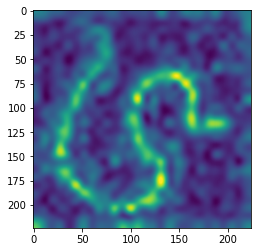

In [18]:
plt.imshow(cam)

In [119]:
def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.65
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

In [61]:
import cv2

In [62]:
img = cv2.imread("./snake.jpg")

In [70]:
img_pil = Image.open("./snake.jpg")

In [133]:
no_trans_heatmap, heatmap_on_image = apply_colormap_on_image(img_pil, cam, "gnuplot2")

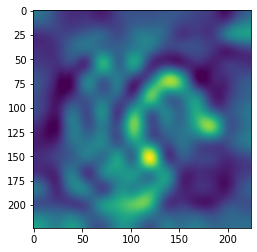

In [134]:
plt.imshow(cam)

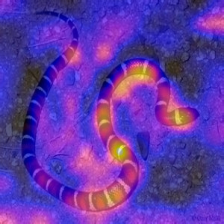

In [11]:
from class_activation_maps import ScoreCam as ScoreCum

In [12]:
dupa = ScoreCum(test_model.model, "layer1")

In [14]:
no_trans, heatmap_image = dupa.generate_cam(example_params[0], "/Users/michalbarrington/Downloads/snake.jpg")

X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
target torch.Size([256, 56, 56])
********

 beginning the cam generation

**********
len of target in 4 loop 256
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.S

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 25

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shap

X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1

x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
X shape before forward pass torch.Size([1, 3, 224, 224])
conv1
x shape after conv1 torch.Size([1, 64, 112, 112])
bn1
x shape after bn1 torch.Size([1, 64, 112, 112])
relu
x shape after relu torch.Size([1, 64, 112, 112])
maxpool
x shape after maxpool torch.Size([1, 64, 56, 56])
layer1
x shape after layer1 torch.Size([1, 256, 56, 56])
X shape in forward pass torch.Size([1, 256, 56, 56])
x shape before fc torch.Size([1, 256])
origin

In [21]:
example_params[0]

tensor([[[[ 0.1768,  0.2111,  0.6734,  ...,  0.3994,  0.5022,  0.5193],
          [ 0.0227,  0.2624,  0.8276,  ...,  0.2796,  0.3652,  0.4508],
          [ 0.2624,  0.5022,  0.9646,  ...,  0.2282,  0.2967,  0.3994],
          ...,
          [ 1.9920,  1.9407,  0.9817,  ...,  1.1015,  0.8961,  0.9474],
          [ 0.9303,  1.5297,  0.2453,  ...,  0.7933,  0.5193,  0.5536],
          [ 0.3652,  1.1529, -0.0972,  ...,  0.8618,  0.6906,  0.8618]],

         [[-0.2675, -0.1625,  0.3452,  ...,  0.0651,  0.1527,  0.1702],
          [-0.3901, -0.1099,  0.4853,  ..., -0.0749,  0.0126,  0.1001],
          [-0.1099,  0.1527,  0.6779,  ..., -0.1450, -0.0574,  0.0476],
          ...,
          [ 1.7458,  1.6933,  0.7129,  ...,  0.9405,  0.6779,  0.7304],
          [ 0.6604,  1.2731, -0.0224,  ...,  0.6254,  0.2927,  0.3277],
          [ 0.1001,  0.9055, -0.3725,  ...,  0.6429,  0.4678,  0.6429]],

         [[-0.8284, -0.7064, -0.1835,  ..., -0.0790,  0.0082,  0.0256],
          [-0.9330, -0.6193,  

In [ ]:
example_params[0][]

In [19]:
kurwa = torchvision.transforms.ToPILImage()

ToPILImage()

In [18]:
kurwa.

ToPILImage(mode=tensor([[[[ 0.1768,  0.2111,  0.6734,  ...,  0.3994,  0.5022,  0.5193],
          [ 0.0227,  0.2624,  0.8276,  ...,  0.2796,  0.3652,  0.4508],
          [ 0.2624,  0.5022,  0.9646,  ...,  0.2282,  0.2967,  0.3994],
          ...,
          [ 1.9920,  1.9407,  0.9817,  ...,  1.1015,  0.8961,  0.9474],
          [ 0.9303,  1.5297,  0.2453,  ...,  0.7933,  0.5193,  0.5536],
          [ 0.3652,  1.1529, -0.0972,  ...,  0.8618,  0.6906,  0.8618]],

         [[-0.2675, -0.1625,  0.3452,  ...,  0.0651,  0.1527,  0.1702],
          [-0.3901, -0.1099,  0.4853,  ..., -0.0749,  0.0126,  0.1001],
          [-0.1099,  0.1527,  0.6779,  ..., -0.1450, -0.0574,  0.0476],
          ...,
          [ 1.7458,  1.6933,  0.7129,  ...,  0.9405,  0.6779,  0.7304],
          [ 0.6604,  1.2731, -0.0224,  ...,  0.6254,  0.2927,  0.3277],
          [ 0.1001,  0.9055, -0.3725,  ...,  0.6429,  0.4678,  0.6429]],

         [[-0.8284, -0.7064, -0.1835,  ..., -0.0790,  0.0082,  0.0256],
          [-0.

In [20]:
type(heatmap_image)

PIL.Image.Image

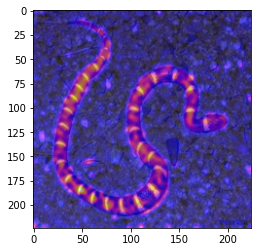

In [17]:
plt.imshow(heatmap_image)

In [23]:
import MapExtrackt

In [24]:
fe = MapExtrackt.FeatureExtractor(test_model.model)

In [21]:
trainloader.dataset.data[0].shape

(32, 32, 3)

In [34]:
test_image = np.transpose(trainloader.dataset.data[0],(2,1,0))

In [35]:
test_image.shape

(3, 32, 32)

In [32]:
os.listdir("../data/all_data/")[0]

['49936617152.jpg',
 '50063881023.jpg',
 '49230564381.jpg',
 '50064438811.jpg',
 '49145004397.jpg',
 '40014095893.jpg',
 '50005269518.jpg',
 '49816627576.jpg',
 '50050873076.jpg',
 '50043507882.jpg',
 '49935791938.jpg',
 '49675252173.jpg',
 '49062300843.jpg',
 '49890023133.jpg',
 '50021620601.jpg',
 '49936096147.jpg',
 '50044356907.jpg',
 '49751811497.jpg',
 '48766994286.jpg',
 '49946713211.jpg',
 '31008001497.jpg',
 '32648995547.jpg',
 '50028572696.jpg',
 '50064217437.jpg',
 '49969488251.jpg',
 '50046941361.jpg',
 '50010579603.jpg',
 '49102748652.jpg',
 '47583074191.jpg',
 '49941764802.jpg',
 '49902348278.jpg',
 '49790622927.jpg',
 '49963581841.jpg',
 '49985225206.jpg',
 '49792521847.jpg',
 '47209032372.jpg',
 '50063881233.jpg',
 '49502381668.jpg',
 '49934077611.jpg',
 '49940401833.jpg',
 '50055292107.jpg',
 '32153049317.jpg',
 '49988128356.jpg',
 '49968976218.jpg',
 '50053507627.jpg',
 '50005454447.jpg',
 '50064439396.jpg',
 '50050794617.jpg',
 '48939698657.jpg',
 '50036210418.jpg',


In [28]:
fe.set_image("/Users/michalbarrington/Downloads/snake.jpg")

RuntimeError: size mismatch, m1: [1 x 2048], m2: [256 x 10] at /Users/distiller/project/conda/conda-bld/pytorch_1579022036889/work/aten/src/TH/generic/THTensorMath.cpp:136

In [27]:
fe.layer_names

[]

In [29]:
fe[conv2d_indexes[40], 0:15]

NameError: name 'conv2d_indexes' is not defined

In [43]:
for module_pos, c in test_model.model._modules.items():
    print(module_pos)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [58]:
test_model.model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

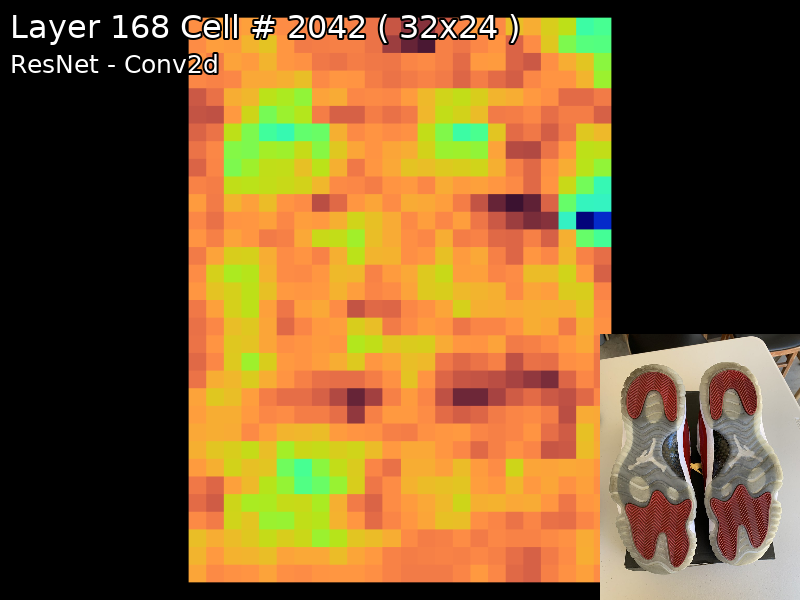

In [97]:
fe[conv2d_indexes[-1],2041]

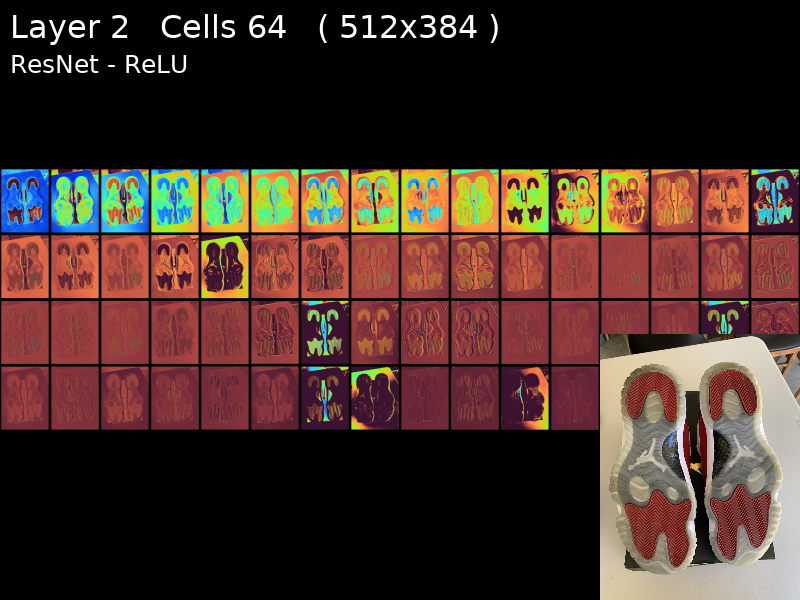

In [85]:
fe[2]

In [66]:
conv2d_indexes = [ i for i,x in enumerate(fe.layer_names) if x == "Conv2d"]

In [115]:
list(list(test_model.model.layer4.children())[0].children())[0].register_forward_hook(get_activation('Conv2d'))

In [63]:
fe.layer_names

['Conv2d',
 'BatchNorm2d',
 'ReLU',
 'MaxPool2d',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Bottleneck (Block)',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 'Conv2d',
 'BatchNorm2d',
 'ReLU',
 '

In [ ]:
import json

In [ ]:
with open("../data/mich5 (1).json", "r") as f:
    
    data_image = json.load(f)

In [ ]:
annon_meta = data_image["_via_img_metadata"]

In [ ]:
x_test = annon_meta['49958388512.jpg101229']["regions"][0]["shape_attributes"]["all_points_x"]
y_test = annon_meta['49958388512.jpg101229']["regions"][0]["shape_attributes"]["all_points_y"]

In [ ]:
plt.plot(x_test,y_test)

In [ ]:
annon_meta['49958388512.jpg101229']["regions"]

In [ ]:
import cv2

In [ ]:
for key, v in annon_meta.items():
    
    filename = v["filename"]
    
    img = cv2.imread(f"../data/all_data/{filename}")
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    for region in v["regions"]:
        
        try:
        
            all_x = region["shape_attributes"]["all_points_x"]
            all_y = region["shape_attributes"]["all_points_y"]

            plt.plot(all_x,all_y)
        except:
            pass
    plt.title(filename)
    plt.show()
        
        
    
    